# Polling Performance

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Watermark" data-toc-modified-id="Watermark-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Watermark</a></span></li><li><span><a href="#File-locations" data-toc-modified-id="File-locations-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>File locations</a></span></li><li><span><a href="#Plotting-stuff" data-toc-modified-id="Plotting-stuff-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Plotting stuff</a></span></li></ul></li><li><span><a href="#Get-data" data-toc-modified-id="Get-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data</a></span><ul class="toc-item"><li><span><a href="#Recent-polling-data" data-toc-modified-id="Recent-polling-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Recent polling data</a></span></li><li><span><a href="#AEC-Enrolment-data" data-toc-modified-id="AEC-Enrolment-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>AEC Enrolment data</a></span></li><li><span><a href="#Latest-AEC-national-count-data" data-toc-modified-id="Latest-AEC-national-count-data-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Latest AEC national count data</a></span><ul class="toc-item"><li><span><a href="#First-preference-votes-nationally" data-toc-modified-id="First-preference-votes-nationally-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>First preference votes nationally</a></span></li><li><span><a href="#Two-party-preferred-votes-by-state" data-toc-modified-id="Two-party-preferred-votes-by-state-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Two party preferred votes by state</a></span></li></ul></li></ul></li><li><span><a href="#Plots" data-toc-modified-id="Plots-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plots</a></span><ul class="toc-item"><li><span><a href="#Explore-primary-polls-vs-election-result" data-toc-modified-id="Explore-primary-polls-vs-election-result-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Explore primary polls vs election result</a></span></li><li><span><a href="#Explore-2pp-Polls-vs-Election-Result" data-toc-modified-id="Explore-2pp-Polls-vs-Election-Result-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Explore 2pp Polls vs Election Result</a></span></li></ul></li><li><span><a href="#The-End" data-toc-modified-id="The-End-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The End</a></span></li></ul></div>

## Python setup

### Imports

In [1]:
# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.patches import Patch

# system imports
from pathlib import Path
import itertools
import numbers
import math
from datetime import datetime
from typing import Any, Union, Iterable, Optional, List, Dict

# local imports
import common

### Watermark

In [2]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Sat May 28 2022 14:38:30

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.3.0

numpy     : 1.22.4
matplotlib: 3.5.2
pandas    : 1.4.2

Watermark: 2.3.1



### File locations

In [3]:
# path to the model data 
PUBLIC_DATA_DIR = '../data/'
Path(PUBLIC_DATA_DIR).mkdir(parents=True, exist_ok=True)

PRIVATE_DATA_DIR = '../historical-data/'
Path(PRIVATE_DATA_DIR).mkdir(parents=True, exist_ok=True)

CHARTS_DIR = '../charts/'
Path(CHARTS_DIR).mkdir(parents=True, exist_ok=True)

### Plotting stuff

In [4]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')
LFOOTER = f'Election data from AEC {datetime.now().now().strftime("%d/%m/%Y %H:%M")}. '
LFOOTER

'Election data from AEC 28/05/2022 14:38. '

## Get data

### Recent polling data

In [5]:
FINAL_POLLING_PERIOD = 4 # days - polls in last few days

def get_last_polls():
    current_polls = f'{PUBLIC_DATA_DIR}primary_vote.csv' 
    polls = pd.read_csv(current_polls, parse_dates=['Mean Date'], index_col=0)
    final_date = polls['Mean Date'].max()
    start_date = final_date - pd.Timedelta(days=FINAL_POLLING_PERIOD)
    retain_polls_mask = ((polls['Mean Date'] >= start_date) 
                         & (polls['Mean Date'] <= final_date))
    return polls[retain_polls_mask]

In [6]:
polls = get_last_polls()
PRIMARIES = {
    'Primary vote L/NP': 'Coalition',
    'Primary vote ALP': 'Labor',
    'Primary vote GRN': 'Green',
    'Primary vote ONP': 'One Nation',
    'Primary vote UAP': 'UAP',
    'Primary vote OTH': 'Other',
}
primary_polls = polls.rename(columns=PRIMARIES)
primary_polls_final_mean = (
    # let's do a sample-size weighted average
    (primary_polls[PRIMARIES.values()]
     .mul(primary_polls['Sample size'], axis=0)).sum() 
    / primary_polls['Sample size'].sum()
)
primary_polls_final_mean

Coalition     35.350493
Labor         34.943326
Green         12.438486
One Nation     4.966181
UAP            2.974027
Other          9.327487
dtype: float64

### AEC Enrolment data

In [7]:
enrolmentByDiv = pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                                       'GeneralEnrolmentByDivisionDownload-27966.txt',
                                       header=1, sep='\t',  skipinitialspace=True)
enrolmentByDiv.index = enrolmentByDiv['DivisionNm']

enrolment_div = enrolmentByDiv.Enrolment
enrolment_state = enrolmentByDiv.groupby('StateAb').sum().Enrolment

### Latest AEC national count data

#### First preference votes nationally

In [8]:
houseFirstPrefsByParty = pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                                       'HouseFirstPrefsByPartyDownload-27966.txt',
                                       header=1, sep='\t',  skipinitialspace=True)
houseFirstPrefsByParty = houseFirstPrefsByParty.set_index(['PartyAb'], drop=True)
houseFirstPrefsByParty.columns

Index(['PartyNm', 'OrderOfAppearance', 'Contested', 'Nominations', 'Elected',
       'OrdinaryVotes', 'OrdinaryPercentage', 'AbsentVotes',
       'AbsentPercentage', 'ProvisionalVotes', 'ProvisionalPercentage',
       'PrePollVotes', 'PrePollPercentage', 'PostalVotes', 'PostalPercentage',
       'TotalVotes', 'TotalPercentage', 'TotalSwing'],
      dtype='object')

In [9]:
# Party groupings
groups = {
    'Coalition': ['LP', 'LNP', 'NP', 'CLP'],
    'Labor': ['ALP'],
    'Green': ['GRN'],
    'One Nation': ['ON'],
    'UAP': ['UAPP'],
}
groups['Other'] = (
    list(set(houseFirstPrefsByParty.index.to_list()) 
         - set(itertools.chain.from_iterable(groups.values())))
)

In [10]:
def get_group_totals(data):
    total_votes = data['TotalVotes'].sum()
    primary_tally = {}
    for label, group in groups.items():
        both = list(set(group).intersection(set(data.index)))
        primary_tally[label] = (
            data
            .loc[both, 'TotalVotes']
            .sum() 
            / total_votes * 100
        )
    return pd.Series(primary_tally)

In [11]:
# current state of primary votes
primary_tally = get_group_totals(houseFirstPrefsByParty)
primary_tally

Coalition     36.180521
Labor         32.758873
Green         11.739886
One Nation     4.855532
UAP            4.074879
Other         10.390308
dtype: float64

#### Two party preferred votes by state

In [12]:
houseTppByState = pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                                       'HouseTppByStateDownload-27966.txt',
                                       header=1, sep='\t',  skipinitialspace=True)

# State name as index - add percent counted to the data
houseTppByState.index = houseTppByState['StateAb']
houseTppByState['Enrolment'] = enrolment_state
houseTppByState['Counted%'] =  houseTppByState['TotalVotes'] / houseTppByState['Enrolment']* 100.0
houseTppByState

,StateAb,StateNm,Liberal/National Coalition Votes,Liberal/National Coalition Percentage,Australian Labor Party Votes,Australian Labor Party Percentage,TotalVotes,Swing,Enrolment,Counted%
StateAb,,,,,,,,,,
NSW,NSW,New South Wales,1595386,48.73,1678864,51.27,3274250,-3.05,5472469,59.831312
VIC,VIC,Victoria,1166234,45.34,1405910,54.66,2572144,-1.52,4344208,59.208583
QLD,QLD,Queensland,1215134,54.90,998198,45.10,2213332,-3.54,3503609,63.172917
WA,WA,Western Australia,507725,44.42,635370,55.58,1143095,-11.13,1773969,64.437146
SA,SA,South Australia,372953,45.70,443187,54.30,816140,-3.59,1272047,64.159579
TAS,TAS,Tasmania,127579,48.92,133202,51.08,260781,4.88,402331,64.817526
ACT,ACT,Australian Capital Territory,62484,35.47,113676,64.53,176160,-2.92,314329,56.043190
NT,NT,Northern Territory,41281,44.14,52233,55.86,93514,-1.66,145938,64.077896


In [13]:
labor_tpp_election = (
    houseTppByState['Australian Labor Party Votes'].sum()
    / (houseTppByState['Australian Labor Party Votes'].sum()
       + houseTppByState['Liberal/National Coalition Votes'].sum())
    * 100
)
labor_tpp_election

51.76248618880893

## Plots

### Explore primary polls vs election result

In [14]:
colours = {
    'Coalition': 'blue',
    'Labor': '#dd0000',
    'Green': 'green',
    'One Nation': 'darkorange',
    'UAP': 'gold',
    'Other': 'darkorchid',
}

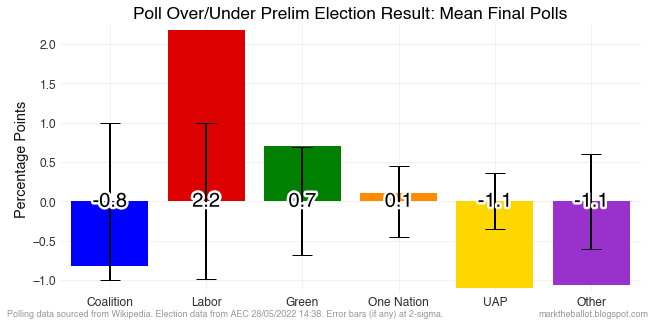

In [15]:
def difference_plot(polls, election, sample_size=None, **kwargs):
    
    SIGMA = 2
    compar = polls - election
    colors = kwargs['colors'] if 'colors' in kwargs else 'darkcyan'
    if type(colors) is str:
        colors = pd.Series([colors]*len(compar), index=compar.index)
 
    fig, ax = common.initiate_plot()
    for x, y in compar.iteritems():
        ax.bar(x, y, color=colors[x])
        text = ax.text(x, 0, f'{y:0.1f}', ha='center', va='center',
            fontsize=20)
        text.set_path_effects([pe.withStroke(linewidth=5, foreground='w')])
        
        if sample_size is not None:
            ss = sample_size if isinstance(sample_size, numbers.Number) else sample_size[x]
            p = polls[x] / 100
            z = np.sqrt((p*(1-p))/ss) * 100
            ax.errorbar(x, 0, yerr=SIGMA*z, ecolor='black', capsize=10)
        
    title = kwargs['title'] if 'title' in kwargs else None
    common.plot_finalise(
        ax, 
        title=title, 
        ylabel='Percentage Points', 
        lfooter='Polling data sourced from Wikipedia. ' +
                LFOOTER + 
                f'Error bars (if any) at {SIGMA}-sigma.', 
    )

difference_plot(primary_polls_final_mean, primary_tally, 
                primary_polls['Sample size'].sum(), 
                colors=colours,
                title='Poll Over/Under Prelim Election Result: Mean Final Polls')

In [16]:
primary_polls.columns

Index(['Coalition', 'Labor', 'Green', 'One Nation', 'UAP', 'Other', 'Date',
       'Mean Date', 'Brand', 'Interview mode', 'Sample size',
       'Calculated 2pp L/NP', 'Calculated 2pp ALP'],
      dtype='object')

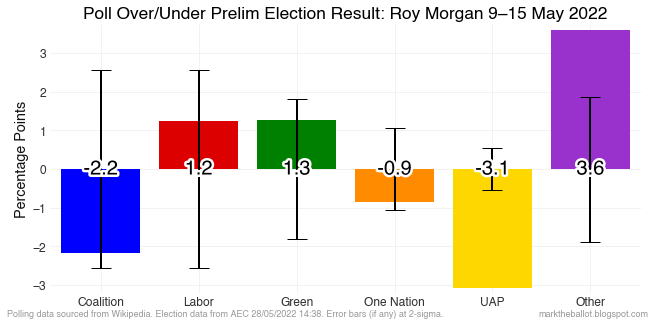

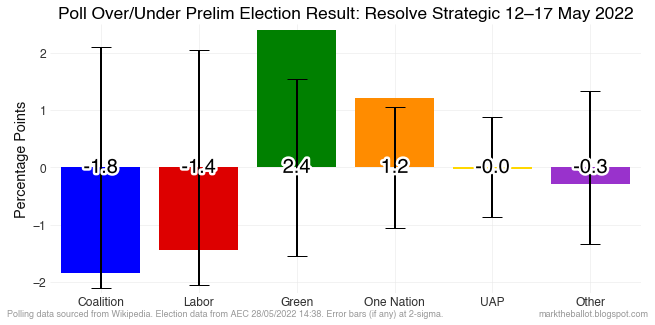

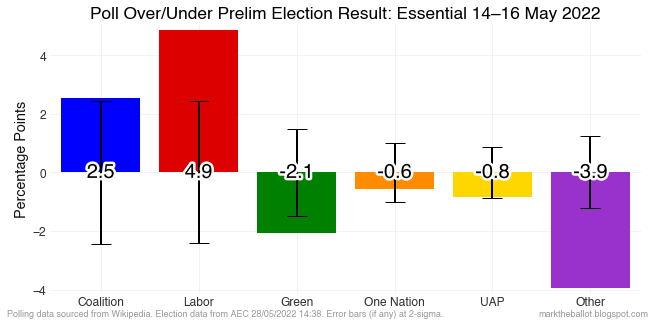

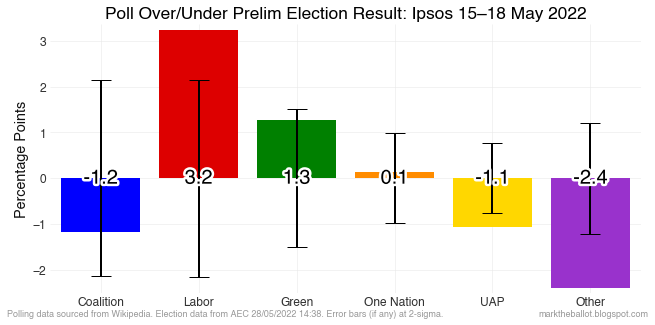

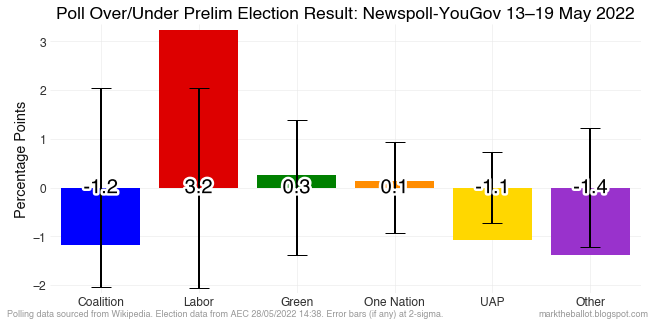

In [17]:
primary_polls.index = primary_polls['Brand'] + ' ' + primary_polls['Date']
for name, poll in primary_polls.iterrows():
    title = f'Poll Over/Under Prelim Election Result: {name}'
    sample_size = poll['Sample size']
    difference_plot(poll[PRIMARIES.values()], primary_tally, 
                    sample_size=sample_size, 
                    colors=colours,
                    title=title)

### Explore 2pp Polls vs Election Result

In [18]:
MFP = 'Mean final polls'
tpp = primary_polls.copy()
tpp.index =  tpp['Brand'] + '\n' +  tpp['Date']
addition = pd.Series([np.nan]*len(tpp.columns), index=tpp.columns, name=MFP)
addition['Sample size'] = tpp['Sample size'].sum()
addition['Calculated 2pp ALP'] = (
    # let's do a weitherd mean
    (tpp['Calculated 2pp ALP'] * tpp['Sample size']).sum()
    / tpp['Sample size'].sum()
)
addition = pd.DataFrame(addition).T
tpp = pd.concat([tpp, addition])

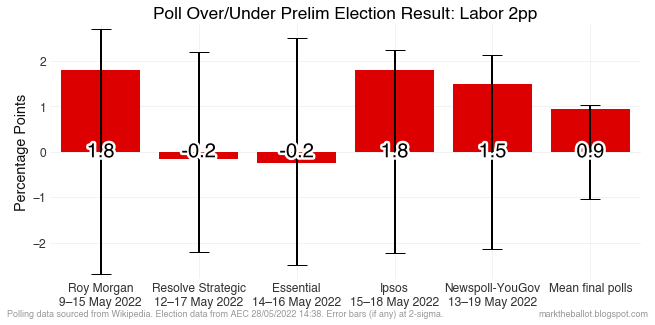

In [19]:
title = 'Poll Over/Under Prelim Election Result: Labor 2pp'
sample_size = poll['Sample size']
difference_plot(tpp['Calculated 2pp ALP'], labor_tpp_election, 
                    sample_size=tpp['Sample size'], 
                    colors='#dd0000',
                    title=title)


## The End

In [20]:
print('Done')

Done
